In [10]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

# Load image lag

In [3]:
all_lags = pd.read_csv('../../../docker_emse/csv/for_analysis/image_lags.csv', dtype=object)
all_lags.shape

(140496, 10)

In [4]:
all_lags.head(2)

,image,release,type,last_updated,cve_lag,bug_lag,vlag,tlag,outdated,packages
0,010309:mmmiddleware:0.9.25,Stable,community,2017-11-01,0.0,0.0,0.0,0.0,0.0,82
1,010309:mmmiddleware:0.9.26,Stable,community,2017-11-12,0.0,0.0,0.0,0.0,0.0,82


In [5]:
all_lags.rename(columns={'outdated':'pkg',
                         'vlag':'version',
                         'tlag':'time',
                         'cve_lag':'vuln',
                         'bug_lag':'bug'
                        }, inplace=True)

In [6]:
for x in ['vuln','bug','time','version','pkg','packages']:
    all_lags[x] = all_lags[x].apply(float)

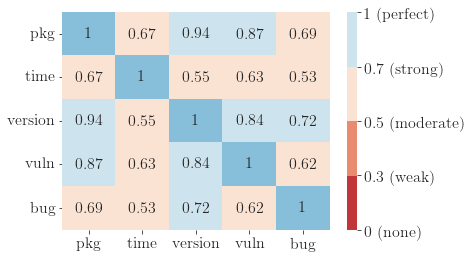

In [12]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

bounds = [0, 0.3, 0.5, 0.7, 1]
labels = ['none', 'weak', 'moderate', 'strong', 'perfect']
base = sns.color_palette('RdBu', n_colors=len(bounds) + 1)

cmap = LinearSegmentedColormap.from_list('segmented', list(zip(bounds, base)), len(bounds))
norm = BoundaryNorm(bounds, ncolors=len(bounds) - 1)

corr = (all_lags
    [['pkg', 'time', 'version', 'vuln', 'bug']]
    .corr(method="pearson")
    [['pkg', 'time', 'version', 'vuln', 'bug']]
)

ax = sns.heatmap(
    corr, 
    annot = True, 
    cmap=cmap, 
    cbar_kws={'ticks': bounds}, 
    norm=norm, 
    vmin=0, 
    vmax=1
)
ax.collections[-1].colorbar.set_ticklabels(['{} ({})'.format(a, b) for a,b in zip(bounds, labels)])
for label in ax.get_yticklabels():
    label.set_verticalalignment('center')

ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/corr-pearson.pdf', bbox_inches='tight', facecolor='white')

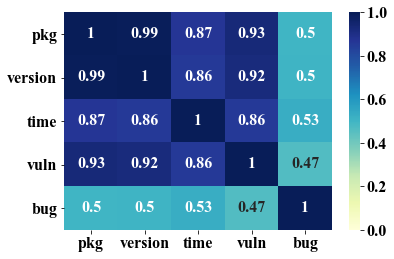

In [8]:
corr = (all_lags
 [['pkg','version','time','vuln','bug']]
 .corr(method="spearman"))
ax=sns.heatmap(corr, annot = True, cmap="YlGnBu", vmin=0, vmax=1)
#ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/corr-spearman.pdf', bbox_inches='tight', facecolor='white')

In [12]:
print('correlation with the number of packages')
for i, col1 in enumerate(['vuln','bug','time','version','pkg']):
    print(col1, scipy.stats.pearsonr(all_lags[col1], all_lags['packages']))

correlation with the number of packages
vuln (0.18256705396190703, 0.0)
bug (0.01704202027291113, 1.678137952857731e-10)
time (0.165418945464823, 0.0)
version (0.1543593141295828, 0.0)
pkg (0.21266599206798795, 0.0)


Text(0.5, 1, 'official - community')

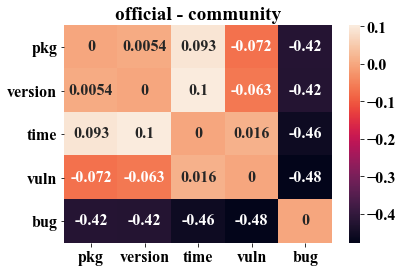

In [13]:
corr = (all_lags
        .query('type=="official"')
        [['pkg','version','time','vuln','bug']]
        .corr(method="spearman"))

corr2 = (all_lags
        .query('type=="community"')
        [['pkg','version','time','vuln','bug']]
        .corr(method="spearman"))

ax=sns.heatmap(corr - corr2, annot = True)
ax.set_title('official - community')
#ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/corr-difference.pdf', bbox_inches='tight', facecolor='white')

# PCA

In [123]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

features = ['pkg', 'time', 'version', 'vuln', 'bug']
# Separating out the features
x = all_lags.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

#x = QuantileTransformer(output_distribution='normal').fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)

In [125]:
pca.explained_variance_ratio_

array([0.76828754, 0.1045065 , 0.08515503, 0.03247034, 0.00958059])

In [127]:
pca.components_

array([[ 0.48899436,  0.3860418 ,  0.47612703,  0.46435453,  0.41174527],
       [ 0.10559078, -0.89506602,  0.34955045,  0.05233007,  0.25056626],
       [ 0.2436482 , -0.11445776,  0.18425882,  0.40642066, -0.85346699],
       [ 0.38856896,  0.11662149,  0.43132475, -0.7842964 , -0.18507216],
       [-0.73442823,  0.15207695,  0.65660123,  0.0365764 , -0.07088561]])

In [153]:
for y in pca.components_:
    print(y/y.sum())

[0.21954945 0.17332565 0.21377226 0.20848662 0.18486603]
[-0.77057558  6.53197196 -2.55093334 -0.381892   -1.82857105]
[-1.82375402  0.85673856 -1.37921303 -3.04213746  6.38836595]
[-11.82737344  -3.54975845 -13.12878639  23.87263882   5.63327945]
[-18.38794445   3.80756405  16.439383     0.91576662  -1.77476922]


In [139]:
df = pd.DataFrame(
    index=['component 1', 'component 2', 'component 3', 'component 4', 'component 5'],
    columns=features,
    data=pca.components_
)
df['explained variance'] = pca.explained_variance_ratio_

In [140]:
df

,pkg,time,version,vuln,bug,explained variance
component 1,0.488994,0.386042,0.476127,0.464355,0.411745,0.768288
component 2,0.105591,-0.895066,0.349550,0.052330,0.250566,0.104506
component 3,0.243648,-0.114458,0.184259,0.406421,-0.853467,0.085155
component 4,0.388569,0.116621,0.431325,-0.784296,-0.185072,0.032470
component 5,-0.734428,0.152077,0.656601,0.036576,-0.070886,0.009581


In [152]:
print(df.to_latex(
    columns=['pkg', 'time', 'version', 'vuln', 'bug', 'explained variance'],
    float_format='{:0.2f}'.format,
    bold_rows=True,
))

\begin{tabular}{lrrrrrr}
\toprule
{} &   pkg &  time &  version &  vuln &   bug &  explained variance \\
\midrule
\textbf{component 1} &  0.49 &  0.39 &     0.48 &  0.46 &  0.41 &                0.77 \\
\textbf{component 2} &  0.11 & -0.90 &     0.35 &  0.05 &  0.25 &                0.10 \\
\textbf{component 3} &  0.24 & -0.11 &     0.18 &  0.41 & -0.85 &                0.09 \\
\textbf{component 4} &  0.39 &  0.12 &     0.43 & -0.78 & -0.19 &                0.03 \\
\textbf{component 5} & -0.73 &  0.15 &     0.66 &  0.04 & -0.07 &                0.01 \\
\bottomrule
\end{tabular}



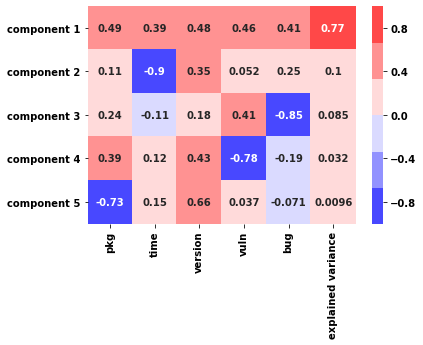

In [145]:
ax = sns.heatmap(
    df, 
    annot = True, 
    cmap=sns.color_palette('bwr'), 
    vmin=-1, 
    vmax=1
)